In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, Image

In [2]:
import logging
import time
import numpy as np

import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncLogger import SyncLogger

URI = f'radio://0/1/2M'

# Only output errors from the logging framework
logging.basicConfig(level=logging.ERROR)

log_keys = ['e_z',
            'e_x',
            'e_roll',
            'e_pitch',]
# log_keys = ['z',
#             'x',
#             'roll',
#             'pitch',]
# log_keys = ['qx',
#             'qy',
#             'qz',
#             'qw',]
other_log_keys = []

entry_count = 0

if __name__ == '__main__':
    cflib.crtp.init_drivers(enable_debug_driver=False)

    with SyncCrazyflie(URI, cf=Crazyflie(rw_cache='./cache')) as scf:
        cf = scf.cf

        lg_stab = LogConfig(name='LQR', period_in_ms=10)
        lg_data = {}

        for key in log_keys:
            lg_stab.add_variable('ctrlLQR.' + key, 'float')
            lg_data[key] = []

        for key in other_log_keys:
            lg_stab.add_variable( key, 'float')
            lg_data[key.split('.')[1]] = []

        # for i in range(4):
        #     for j in range(12):
        #         cf.param.set_value(f'ctrlLQR.k{i + 1}{j + 1}', '{:.6f}'.format(K[i, j]))
        # cf.param.set_value(f'ctrlLQR.k{0 + 1}{2 + 1}', '{:.6f}'.format(K[0, 2]))

        cf.param.set_value('kalman.resetEstimation', '1')  # will reset all states
        time.sleep(0.1)
        cf.param.set_value('kalman.resetEstimation', '0')
        time.sleep(2)
        print('Reset Kalman filter.')
            
        print('Switching to LQR!')
        cf.param.set_value('stabilizer.controller', '1')
        for y in range(15):
            cf.commander.send_position_setpoint(0, 0, y / 25, 0)
            time.sleep(0.2)
        print('Taking off!')   
         
        cf.param.set_value('stabilizer.controller', '3')  # re-initialize after each (unresetted) run
        cf.commander.send_position_setpoint(0, 0, 0.5, 0)
        # time.sleep(4)

        with SyncLogger(scf, lg_stab) as logger:
            t_start = time.time()


            for log_entry in logger:
                delta_t = time.time() - t_start
                # if delta_t < 1:
                #     cf.commander.send_position_setpoint(0, 0, delta_t*10 / 25, 0)
                # else:
                cf.commander.send_position_setpoint(0.5, 0, 0.5, 0)
                for key, value in log_entry[1].items():
                    lg_data[key.split('.')[1]].append(value)

                entry_count += 1

                if delta_t > 5:  # x100 data points
                    break

        print('Saving data...')
        for key in lg_data.keys():
            lg_data[key] = np.array(lg_data[key])

        np.savez('quad_data/quad_traj', **lg_data)

        for y in range(10):
            cf.commander.send_position_setpoint(0.5, 0, (10 - y) / 25, 0)
            time.sleep(0.15)

        for i in range(10):
            cf.commander.send_stop_setpoint()
            time.sleep(0.1)

print('Done!') 

Reset Kalman filter.
Switching to LQR!
Taking off!


KeyError: 'Variable ctrlLQR.e_z not in TOC'

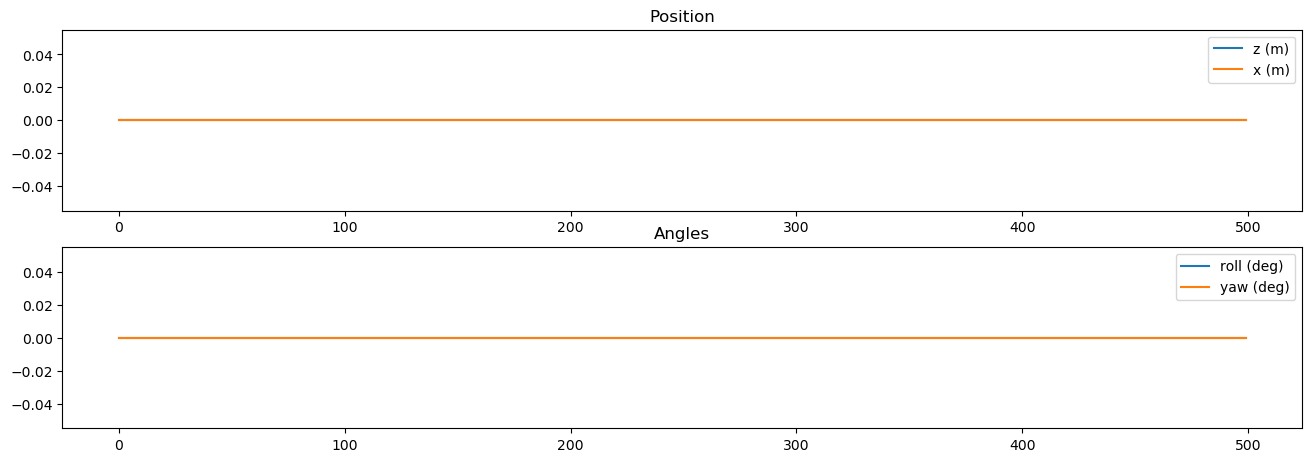

In [ ]:
import os

if os.path.isfile('quad_data/quad_traj.npz'):
    npzfile = np.load('quad_data/quad_traj.npz')

    plt.rcParams["figure.figsize"] = (16,8)
    fig = plt.figure()

    ax = fig.add_subplot(311, title='Position')
    ax.plot(npzfile['e_z'][:entry_count], label='z (m)')
    ax.plot(npzfile['e_x'][:entry_count], label='x (m)')
    ax.legend()

    ax = fig.add_subplot(312, title='Angles')
    ax.plot(npzfile['e_roll'][:entry_count], label='roll (deg)')
    ax.plot(npzfile['e_pitch'][:entry_count], label='yaw (deg)')
    ax.legend()

    # ax = fig.add_subplot(313, title='Moments')
    # ax.plot(npzfile['u2_pwm'][:125] / (2 ** 15), label='M1')
    # ax.plot(npzfile['u3_pwm'][:125] / (2 ** 15), label='M2')
    # ax.legend()
else:
    print('No flight data found.')

In [ ]:
npzfile['z']

array([0.35615903, 0.35971257, 0.36323771, 0.36673054, 0.37066218,
       0.37404823, 0.3773264 , 0.38048077, 0.38447988, 0.3874194 ,
       0.39019841, 0.39280674, 0.39628091, 0.39858252, 0.40069339,
       0.40260464, 0.40431127, 0.4053084 , 0.40658489, 0.40767157,
       0.40858078, 0.40762782, 0.4080942 , 0.40841377, 0.40858817,
       0.4099009 , 0.40989423, 0.40978876, 0.40960011, 0.40810895,
       0.40775433, 0.4073666 , 0.40696752, 0.40655047, 0.40555739,
       0.40514466, 0.4047837 , 0.40447834, 0.40336531, 0.4031603 ,
       0.40303046, 0.40298522, 0.40301791, 0.4031502 , 0.40339997,
       0.40375069, 0.40418825, 0.40463427, 0.40525177, 0.40597293,
       0.40673399, 0.40619057, 0.40703195, 0.40794188, 0.40886316,
       0.40915188, 0.41025385, 0.41127315, 0.41235572, 0.41342622,
       0.41356868, 0.41463757, 0.41570756, 0.41678852, 0.41590437,
       0.41685832, 0.4177933 , 0.41872776, 0.4197897 , 0.42070869,
       0.42162046, 0.42250949, 0.42338842, 0.42451799, 0.42539